## Set the paths

In [1]:
import yaml

with open('configs/paths.yaml', 'r') as stream:
    PATHS = yaml.safe_load(stream)

## Define useful functions and get some stats

DATASET,number of dialogues,number of utterances
-------,-------------------,--------------------
"train, before removal",1038,9989
"train, after removal",978,7523
-------,-------------------,--------------------
"dev, before removal",114,1108
"dev, after removal",110,860
-------,-------------------,--------------------
"test, before removal",280,2610
"test, after removal",269,1983
-------,-------------------,--------------------


DATASET,fps,number of videos
-------,---,----------------
train,24,7487
train,25,36
-------,---,----------------
dev,24,855
dev,25,5
-------,---,----------------
test,24,1970
test,25,13
-------,---,----------------


DATASET,emotion,number of videos,ratio
-------,-------,----------------,-----
train,neutral,3445,0.458
train,surprise,934,0.124
train,fear,208,0.028
train,sadness,541,0.072
train,joy,1289,0.171
train,disgust,219,0.029
train,anger,887,0.118
-------,-------,----------------,-----
dev,neutral,352,0.409


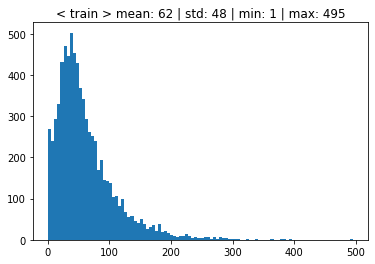

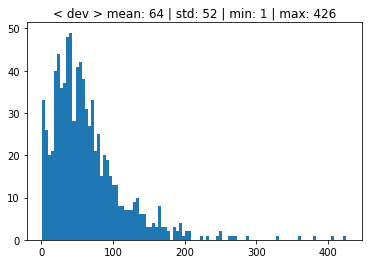

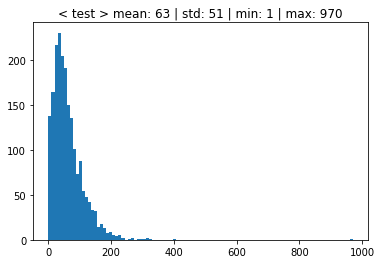

In [2]:
import os
from glob import glob
from tqdm.notebook import tqdm
from IPython.display import HTML, display
import av
import numpy as np
import tabulate
from collections import Counter
import matplotlib.pyplot as plt

with open(PATHS['ANNOTATIONS']['all'], 'r') as stream:
    datasets = yaml.safe_load(stream)

def get_unique_dias(list_of_diautts):
    return sorted(list(set([diautt.split('_')[0] for diautt in list_of_diautts])))

def remove_non_existent(dia_diautts, vid_dir):
    dia_diautts_clean = {}

    for dia, diautts in dia_diautts.items():
        foo = []
        for diautt in diautts:
            if os.path.isfile(os.path.join(vid_dir, diautt + '.mp4')):
                foo.append(diautt)
        if len(foo) != 0:
            dia_diautts_clean[dia] = foo


    return dia_diautts_clean

table = [['DATASET', 'number of dialogues', 'number of utterances']]
table.append('-'*len(foo) for foo in table[0])

dia_diautts = {}
for DATASET in ['train', 'dev', 'test']:
    dia_diautts[DATASET] = list(datasets[DATASET].keys())
    dia_diautts[DATASET] = {dia: [diautt for diautt in dia_diautts[DATASET] if dia + '_' in diautt] 
                    for dia in get_unique_dias(dia_diautts[DATASET])}

    table.append([DATASET + ', before removal', len(dia_diautts[DATASET]), len([diautt for dia, diautts in dia_diautts[DATASET].items() for diautt in diautts ])])

    dia_diautts[DATASET] = remove_non_existent(dia_diautts[DATASET], PATHS['FACE_VIDEOS'][DATASET])
    
    table.append([DATASET+ ', after removal', len(dia_diautts[DATASET]), len([diautt for dia, diautts in dia_diautts[DATASET].items() for diautt in diautts ])])

    table.append('-'*len(foo) for foo in table[0])


display(HTML(tabulate.tabulate(table, tablefmt='html')))


table = [['DATASET', 'fps', 'number of videos']]
table.append('-'*len(foo) for foo in table[0])

fps_all = {}
frames_all = {}
for DATASET in ['train', 'dev', 'test']:
    fps_all[DATASET] = []
    frames_all[DATASET] = []
    for dia, diautts in dia_diautts[DATASET].items():
        for diautt in diautts:
            vidpath = os.path.join(PATHS['FACE_VIDEOS'][DATASET], diautt +'.mp4')
            container = av.open(vidpath)
            fps_all[DATASET].append(round(float(container.streams.video[0].average_rate)))
            frames_all[DATASET].append(container.streams.video[0].frames)
    
    stats = dict(Counter(fps_all[DATASET]))
    for key, val in stats.items():
        table.append([DATASET, key, val])
    table.append('-'*len(foo) for foo in table[0])


display(HTML(tabulate.tabulate(table, tablefmt='html')))


for DATASET in ['train', 'dev', 'test']:
    plt.figure();
    plt.hist(frames_all[DATASET], bins=100);
    plt.title(f"< {DATASET} > mean: {int(np.mean(frames_all[DATASET]).round())} | "
                f"std: {int(np.std(frames_all[DATASET]).round())} | "
                f"min: {np.min(frames_all[DATASET])} | "
                f"max: {np.max(frames_all[DATASET])}");

table = [['DATASET', 'emotion', 'number of videos', 'ratio']]
table.append('-'*len(foo) for foo in table[0])

emotions_all = {}
for DATASET in ['train', 'dev', 'test']:
    emotions_all[DATASET] = []
    for dia, diautts in dia_diautts[DATASET].items():
        for diautt in diautts:
            emotions_all[DATASET].append(datasets[DATASET][diautt]['Emotion'])
    stats = dict(Counter(emotions_all[DATASET]))
    
    for EMO in ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']:
        table.append([DATASET, EMO, stats[EMO], round(stats[EMO]/sum(stats.values()), 3)])

    table.append('-'*len(foo) for foo in table[0])
display(HTML(tabulate.tabulate(table, tablefmt='html')))


## Data generator

In [5]:
from erc.datasets.meld import MeldDataset
import torch

In [6]:
md = MeldDataset([os.path.join(PATHS['FACE_VIDEOS']['train'], bar + '.mp4') for foo in dia_diautts['train'].values() for bar in foo], [datasets['train'][bar]['Emotion'].lower() for foo in dia_diautts['train'].values() for bar in foo])

md_gen = torch.utils.data.DataLoader(md, batch_size=1, shuffle=True)

In [10]:
for images_batch, labels_batch in md_gen:
    print(images_batch.shape, labels_batch)
    break

torch.Size([1, 78, 3, 224, 224]) tensor([6])
